![A Tanzanian Water Well](https://miro.medium.com/max/1174/1*haY1-_3kNC06u6eri83jZw.png)

# Tanzanian Water Well Analysis

**Authors:** Juan Acosta, Drew Holcombe, and Raul Torres
***

# Overview

Tanzania is one of many countries facing water shortages in the face of climate change. In our dataset, provided by Taarifa and the Tanzanian Ministry of Water via DrivenData's competition "Pump it Up: Data Mining the Water Table," nearly half of the wells we studied are non-functional or in need of repair, which leaves countless people and families without reliable water access. We achieved an 85% accurate model which predicts which wells are functional, non-functional, and in need of repair. The most important features included Water Quantity, Extraction Type, and Payment Type: by accessing waterpoints with ample available water, well-documented and established extraction types, and requiring payment from users, we believe the Tanzania Water Fund can construct new wells with the best chance of lasting success.

# Business Problem

As with any nonprofit, the Tanzania Water Fund has finite resources to fulfill their objective of bring clean water to the people of Tanzania; when attempting to provide reliable water access, it is imperitive that new wells stay functional. As identifying the functionality of currently existing wells is rather apparent, we aimed to look to the future and optimize future construction: what factors would result in high-functioning wells? This would allow the organization's resources to be efficiently allocated and establish the most reliable water access possible.

# Data Understanding

Our data is sourced from Taarifa and the Tanzanian Ministry of Water, and was accessed through DrivenData's competition "Pump it Up: Data Mining the Water Table." This data came from two dataframes: One, henceforth "train_labels," is a table where each of the 59400 rows represents a well, and is comprised of two columns: each well's ID, and its functionality (our target variable). The second, henceforth "train_values," contains the same wells, also with a unique ID. This table includes 39 contributing variables. We combined these tables in order to view the varaibles together, then analyzed their contents to determine what contributing variables were usable for modelling purposes. Ultimately, due to a large number of missing values and insufficient data descriptions, we found only 9 contributing variables with data that we could use for our model.

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, roc_curve, auc, plot_roc_curve, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
! ls ".\data"

training_set_labels.csv
training_set_values.csv


Our data is split between two files - labels and values. The source also included a "test set"; however, this set did not contain the wells' functionality, our target variable. As such, we'll treat the "training data" as our full dataset.

In [3]:
train_values = pd.read_csv("./data/training_set_values.csv")
train_labels = pd.read_csv("./data/training_set_labels.csv")

In [4]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [5]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


The data will be easiest to work with if we merge the two.

In [6]:
df = train_values.merge(train_labels)

The columns are described [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/), but the information provided is far from exhaustive, and many terms are not defined. We'll have to explore what we can work with, and what we're unable to understand and, by extension, present.

# Data Preparation

Nulls are found throughout the dataset, which will have to be handled on a case-by-case basis. We'll also have to deal with variables that are not defined in a way that we can understand.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [8]:
# Date recorded is formatted as an object - we'll convert it into a
# timestamp so we can work with it more easily.
df["date_recorded"] = pd.to_datetime(df["date_recorded"])

In [9]:
df["status_group"].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

## Columns Lacking Usable/Useful Information

In [10]:
drop_columns = []

In [11]:
df["id"].value_counts()

2047     1
72310    1
49805    1
51852    1
62091    1
        ..
46396    1
36155    1
34106    1
38200    1
0        1
Name: id, Length: 59400, dtype: int64

These unique IDs are not helpful, as we already have the index of the df anyway.

In [12]:
drop_columns.append("id")

The date_recorded and recorded_by also wouldn't be contributing factors; we'll drop this as well.

In [13]:
drop_columns.extend(["date_recorded", "recorded_by"])

In [14]:
df["public_meeting"].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

This column is described only as "true/false." As we cannot report on it, this column will need to be dropped from our analysis.

In [15]:
drop_columns.append("public_meeting")

In [16]:
df['num_private'].value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

This column also has no description from the source, so we'll drop it as well.

In [17]:
drop_columns.append("num_private")

In [18]:
df["wpt_name"].value_counts()

none                 3563
Shuleni              1748
Zahanati              830
Msikitini             535
Kanisani              323
                     ... 
Kwa Mzee Mirrumbe       1
Kwa Nyamgomela          1
Kwamananasi             1
Kwa Amini John          1
Dp 6                    1
Name: wpt_name, Length: 37400, dtype: int64

This column indicates specific waterpoints, but with so many unique waterpoints represented in the set (waterpoints with only one well), it won't give our model useful information.

In [19]:
drop_columns.append("wpt_name")

In [20]:
df["installer"].isna().sum()

3655

In [21]:
list(df["installer"].unique())

['Roman',
 'GRUMETI',
 'World vision',
 'UNICEF',
 'Artisan',
 'DWE',
 'DWSP',
 'Water Aid',
 'Private',
 'DANIDA',
 'Lawatefuka water sup',
 'WEDECO',
 'Danid',
 'TWE',
 'ISF',
 'Kilolo Star',
 'District council',
 'Water',
 'WU',
 nan,
 'Not known',
 'Central government',
 'CEFA',
 'Commu',
 'Accra',
 'World Vision',
 'LGA',
 'MUWSA',
 'KKKT _ Konde and DWE',
 'Government',
 'Olgilai village community',
 'KKKT',
 'RWE',
 'Adra /Community',
 'SEMA',
 'SHIPO',
 'HESAWA',
 'ACRA',
 'Community',
 'IFAD',
 'Sengerema Water Department',
 'HE',
 'ISF and TACARE',
 'Kokeni',
 'DA',
 'Adra',
 'ALLYS',
 'AICT',
 'KIUMA',
 'CES',
 'District Counci',
 'Ruthe',
 'Adra/Community',
 'Tulawaka Gold Mine',
 'KKT C',
 'Hesawa',
 'Water board',
 'LOCAL CONTRACT',
 'WFP',
 'LIPS',
 'TASAF',
 'World',
 '0',
 'SW',
 'Shipo',
 'Fini water',
 'Kanisa',
 'OXFARM',
 'VILLAGE COUNCIL Orpha',
 'Villagers',
 'Idara ya maji',
 'FPCT',
 'WVT',
 'Ir',
 'DANID',
 'Angli',
 'secondary school',
 'Amref',
 'JBG',
 'DAD

Unfortunately, the installer column is not well-formatted. We see a number of versions of the same concept (particularly versions of "unknown," "government," and various school groups). As such, while this could be useful information, we do not have time to clean this data and will have to drop this column. With additional time and resources, this could be worth revisiting. 

In [22]:
drop_columns.append("installer")

In [23]:
df["funder"].isna().sum()

3635

In [24]:
df["funder"].value_counts()

Government Of Tanzania          9084
Danida                          3114
Hesawa                          2202
Rwssp                           1374
World Bank                      1349
                                ... 
Kkkt Canal                         1
Motiba Wambura                     1
Kamama                             1
Gurdians                           1
Diocese Of Mount Kilimanjaro       1
Name: funder, Length: 1897, dtype: int64

In [25]:
list(df["funder"].unique())

['Roman',
 'Grumeti',
 'Lottery Club',
 'Unicef',
 'Action In A',
 'Mkinga Distric Coun',
 'Dwsp',
 'Rwssp',
 'Wateraid',
 'Isingiro Ho',
 'Private',
 'Danida',
 'World Vision',
 'Lawatefuka Water Supply',
 'Biore',
 'Rudep',
 'Hesawa',
 'Twe',
 'Isf',
 'African Development Bank',
 'Government Of Tanzania',
 'Sobodo',
 'Water',
 'Private Individual',
 'Undp',
 nan,
 'Not Known',
 'Kirde',
 'Cefa',
 'Ces(gmbh)',
 'European Union',
 'Lga',
 'District Council',
 'Muwsa',
 'Dwe/norad',
 'Kkkt_makwale',
 'Sawaka',
 'Ces (gmbh)',
 'Olgilai Village Community',
 'Kkkt',
 'Roman Catholic',
 'Norad',
 'Adra',
 'Sema',
 'Piusi',
 'Dwe',
 'Rc Church',
 'Swisland/ Mount Meru Flowers',
 'Ifad',
 'Swedish',
 'Idc',
 'He',
 'Isf/tacare',
 'Jica',
 'Mzee Sh',
 'Aict',
 'Tcrs',
 'Kiuma',
 'Germany Republi',
 'Netherlands',
 'Ruthe',
 'Tulawaka Gold Mine',
 'Nethalan',
 'Tasaf',
 'Concern World Wide',
 'Wfp',
 'Lips',
 'Sida',
 'World Bank',
 'Tanza',
 '0',
 'Sw',
 'Shipo',
 'Fini Water',
 'Kanisa',
 'Ox

As with the "installer" column, we do not have the time or resources to parse through the messy data in this column. As such, we'll drop this one as well.

In [26]:
drop_columns.append("funder")

In [27]:
print(df["management"].value_counts())

print('-----------------------------')

print(df['management_group'].value_counts())

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64
-----------------------------
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64


These columns, which explore the same concept with differing levels of specificity, are not well-defined in our source material. Barring understanding of these terms and acronyms, we'll have to drop them from our model - we will not be able to describe them intelligently without additonal information. As such, these will also be dropped from our model.

In [28]:
drop_columns.extend(["management", "management_group"])

In [29]:
df["permit"].isna().sum()

3056

In [30]:
df["permit"].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

Due to the large amount of null values here, we're going to drop this column.

In [31]:
drop_columns.append("permit")

## Columns With Similar Descriptions

We have a large number of columns indicating the location of the wells. Let's look at them all:

In [32]:
print(df["region_code"].value_counts())

print('-----------------------------')

print(df['district_code'].value_counts())

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64
-----------------------------
1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64


With no documentation of what these numbers correspond to, we'll need to drop these columns.

In [33]:
drop_columns.extend(["region_code", "district_code"])

 Let's explore the other location descriptions.

In [34]:
print(df['basin'].value_counts())

print('-----------------------------')

print(df['subvillage'].value_counts())

print('-----------------------------')

print(df['region'].value_counts())

print('-----------------------------')

print(df['lga'].value_counts())

print('-----------------------------')

print(df['ward'].value_counts())

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64
-----------------------------
Madukani       508
Shuleni        506
Majengo        502
Kati           373
Mtakuja        262
              ... 
Laghanga         1
Konyeki          1
Mponda           1
Mwalubandwa      1
Sareni           1
Name: subvillage, Length: 19287, dtype: int64
-----------------------------
Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa     

Given these are describing the same thing (the location) with varrying levels of specificity, we'll need to narrow these down to a single column.

Based on background research, while the subvillages are the most specific of the location data, they are rather unweildy; many cannot be found by a google search. As such, we'll use the slightly less-specific, but more wieldy "ward" column.

Coordinates for individual wells are also given; as we do not have tools to work with these meaningfully, we'll drop them from the set.

In [35]:
drop_columns.extend(["lga", "latitude", "longitude", "subvillage", "region", "basin"])

There are a number of pairs or small groups of columns with identical descriptions, similar to the location. Let's look through them; we'll be keeping the most specific columns.

In [36]:
print(df['water_quality'].value_counts())

print('-----------------------------')

print(df['quality_group'].value_counts())

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64
-----------------------------
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64


The two have almost identical data; the main difference is the division of the "salty abandoned" and "flouride abandoned" columns in the water_quality column. We'll drop this column in favor of the water_quality column.

In [37]:
drop_columns.append("quality_group")

Similarly, quantity and quantity_group also have identical descriptions.

In [38]:
print(df['quantity'].value_counts())

print('-----------------------------')

print(df['quantity_group'].value_counts())

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64
-----------------------------
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64


These are identical, so we'll arbitrarily drop quantity_group.

In [39]:
drop_columns.append("quantity_group")

In [40]:
print(df['source'].value_counts())

print('-----------------------------')

print(df['source_type'].value_counts())

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64
-----------------------------
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64


We'll keep source since it distinguishes a handful of values that are grouped together in from source_type:
   1. "other" is split into "other" and "unknown" 
   2. "river/lake" is split into "river" and "lake"
   3. "borehole" is split into "hand dtw" and "machine dbh"

In [41]:
drop_columns.append("source_type")

In [42]:
print(df['waterpoint_type'].value_counts())

print('-----------------------------')

print(df['waterpoint_type_group'].value_counts())

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
-----------------------------
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


We'll keep the more specific classifications of waterpoint_type. 

In [43]:
drop_columns.append("waterpoint_type_group")

In [44]:
print(df['extraction_type'].value_counts())

print('-----------------------------')

print(df['extraction_type_group'].value_counts())

print('-----------------------------')

print(df['extraction_type_class'].value_counts())

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64
-----------------------------
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
indi

The most specific column is extraction_type; we'll drop the other two.

In [45]:
drop_columns.extend(["extraction_type_group", "extraction_type_class"])

In [46]:
print(df['payment'].value_counts())

print('-----------------------------')

print(df['payment_type'].value_counts())

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64
-----------------------------
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


These two are identical except for having slightly different naming conventions, so we'll arbitrarily drop payment_type.

In [47]:
drop_columns.append("payment_type")

## Columns with Missing Values

In [48]:
df['construction_year'].value_counts().head()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
Name: construction_year, dtype: int64

This column is missing nearly half its values, so we'll drop it.

In [49]:
drop_columns.append("construction_year")

In [50]:
df['population'].value_counts().head()

0      21381
1       7025
200     1940
150     1892
250     1681
Name: population, dtype: int64

This is also a large number of missing values; additionally, there are a large number of populations of "1" which are highly implausible. Futher, the area the population number refers to is unclear. We'll drop this column as well.

In [51]:
drop_columns.append("population")

In [52]:
df["amount_tsh"].value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

In [53]:
df.loc[df["amount_tsh"] == 0]["status_group"].value_counts()

functional                 19706
non functional             18885
functional needs repair     3048
Name: status_group, dtype: int64

Interestingly, we have a large number of wells that supposedly have no available water, yet over half of them are listed as being functional. Given the rest of the dataset often uses 0 in place of unknown values, this column seems unreliable. As such, we'll have to drop this column.

In [54]:
drop_columns.append("amount_tsh")

In [55]:
df["gps_height"].value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

Similarly to amount_tsh, we don't have a good way to work around which values of 0 are authentic and which are actually nulls. As such, while this feature could be interesting, we'll have to drop it.

In [56]:
drop_columns.append("gps_height")

In [57]:
print(df["scheme_management"].isna().sum())

print('-----------------------------')

print(df['scheme_name'].isna().sum())

3877
-----------------------------
28166


Due to having so many nulls in a categorical variable, we'll have to delete these columns.

In [58]:
drop_columns.extend(["scheme_management", "scheme_name"])

In [59]:
df_clean = df.drop(columns=drop_columns)

In [60]:
df_clean.shape

(59400, 9)

## Preprocessing Data

In [61]:
#spliting train and test sets
X = df_clean.drop(columns='status_group')
y = df_clean['status_group']

X_train, X_test, y_train, y_test  =  train_test_split(X, y,  random_state=40)

X_train.shape, X_test.shape

((44550, 8), (14850, 8))

In [62]:
#one hot encoding features

ohe = OneHotEncoder(handle_unknown='ignore')

X_dummie_train = ohe.fit_transform(X_train)
X_dummie_test = ohe.transform(X_test)

print(X_dummie_train.shape, X_dummie_test.shape)

(44550, 2144) (14850, 2144)


In [63]:
#Encoding targets
encoder = LabelEncoder()

y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

In [64]:
#Checking for imbalance in our target variable

y_train.value_counts(normalize=False)

functional                 24159
non functional             17186
functional needs repair     3205
Name: status_group, dtype: int64

Because there is a strong imbalance, particularly with the "functional needs repair" group, we're going to use SMOTE before modeling.

In [65]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

X_train_resample, y_train_resample = sm.fit_resample(X_dummie_train, y_train_enc)

# Data Modeling

Our initial dummy model was a standard most_frequent strategy, which gave us an accuracy of around 54% on both our training and testing data.

We started with a decision tree model, which returned an accuracy of 90% on our training data and 82% on our test data. To address the overfitting, we performed a series of random forest and gridsearches, identifying hyperparameters that would improve the model's performance on unseen data. We looked for the accuracy column because we were equally interested in correctly identifying all three states of functionality: we were not specifically seeking out any one type of well.

Ultimately, our final model returned an accuracy of PERCENT on testing data.

## Dummie Model

In [66]:
dummy_clf = DummyClassifier()

In [67]:
# For a dummie model, there's no need to use the SMOTE data

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_resample, y_train_resample)

dummy_clf.score(X_dummie_train, y_train_enc)

0.5422895622895623

In [68]:
dummy_clf.score(X_dummie_test, y_test_enc)

0.5454545454545454

## Decision Tree

In [69]:
Simple_tree = DecisionTreeClassifier(random_state=42)

Simple_tree.fit(X_train_resample, y_train_resample)

DecisionTreeClassifier(random_state=42)

In [70]:
cv_results = cross_validate(
                    estimator=Simple_tree,
                    X=X_train_resample,
                    y=y_train_resample,
                    cv=10,
                    return_train_score=True, 
                    n_jobs=-2)

In [71]:
cv_results['train_score'].mean()

0.9015243322980604

In [72]:
cv_results['test_score'].mean()

0.8251184360065563

Our initial decision tree is okay, but is definitely overfit.

## Random Forest

In [73]:
RF_cls = RandomForestClassifier(random_state=42)

RF_cls.fit(X_train_resample, y_train_resample)

RandomForestClassifier(random_state=42)

In [74]:
RF_cls.score(X_train_resample, y_train_resample)

0.9001062406004664

In [75]:
cv_results = cross_validate(
                    estimator=RF_cls,
                    X=X_train_resample,
                    y=y_train_resample,
                    cv=10,
                    return_train_score=True, 
                    n_jobs=-2)

In [76]:
cv_results['train_score'].mean()

0.901509001717077

In [77]:
cv_results['test_score'].mean()

0.8378672487146238

We're getting an overfit model here as well, only marginally better than our decision tree. Let's investigate further.

## RandomizedSearchCV

<br>

We'll use RandomizedSearch to look for random best parameters, and use them as starting point before gridsearching.

As this is a computationally expensive process, the below code is not set to run. Our results are written below each cell in markdown.

In [78]:
grid_space={'bootstrap': [True, False], 
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
            'max_features': ['auto', 'sqrt'], 
            'min_samples_leaf': [1, 2, 4], 
            'min_samples_split': [2, 5, 10], 
            'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [79]:
# random_search = RandomizedSearchCV(estimator = RF_cls, 
#                                    param_distributions = grid_space, 
#                                    n_iter = 100, 
#                                    cv = 10, 
#                                    verbose=2, 
#                                    random_state=42, 
#                                    n_jobs = -2)


# random_search.fit(X_train_resample, y_train_resample)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),

                   n_iter=100, n_jobs=-2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [80]:
# RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
#                    n_iter=100, n_jobs=-2,
#                    param_distributions={'bootstrap': [True, False],
#                                         'max_depth': [10, 20, 30, 40, 50, 60,
#                                                       70, 80, 90, 100, None],
#                                         'max_features': ['auto', 'sqrt'],
#                                         'min_samples_leaf': [1, 2, 4],
#                                         'min_samples_split': [2, 5, 10],
#                                         'n_estimators': [200, 400, 600, 800,
#                                                          1000, 1200, 1400, 1600,
#                                                          1800, 2000]},
#                    random_state=42, verbose=2)

In [81]:
# random_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=200,

                        random_state=42)

In [82]:
RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=200,
                        random_state=42)

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=200,
                       random_state=42)

In [83]:
# random_search.best_score_

0.8425446923154013

In [84]:
# random_search.best_params_

{'n_estimators': 200,

 'min_samples_split': 2,
 
 'min_samples_leaf': 1,
 
 'max_features': 'sqrt',
 
 'max_depth': None,
 
 'bootstrap': False}

In [85]:
# random_search.classes_

array([0, 1, 2])

In [86]:
# random_search.n_features_in_

2144

###### Built Random Forest model using best parameters from RandomSearch

In [87]:
RF_cls2 = RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=200, 
                                 random_state=42, n_jobs=-2)

RF_cls2.fit(X_train_resample, y_train_resample)

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=200,
                       n_jobs=-2, random_state=42)

In [88]:
RF_cls2.score(X_train_resample, y_train_resample)

0.9001200380810463

In [89]:
RF_cv = cross_validate(
                    estimator=RF_cls2,
                    X=X_train_resample,
                    y=y_train_resample,
                    cv=10,
                    return_train_score=True, 
                    n_jobs=-2)

In [90]:
RF_cv['train_score'].mean()

0.9015243322980604

In [91]:
RF_cv['test_score'].mean()

0.8425446923154013

This test score is, again, incrementally better than our previous models.

# GridSearchCV

Now, we'll start tuning the given "best-parameter", and run a GridSearch with a small combination of them.

In [92]:
"""
Best parameters


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}
 """

"\nBest parameters\n\n\n{'n_estimators': 200,\n 'min_samples_split': 2,\n 'min_samples_leaf': 1,\n 'max_features': 'sqrt',\n 'max_depth': None,\n 'bootstrap': False}\n "

We'll try adjusting some of our variables and look for a possible improvement.

#### 1st GridSearchCV

In [93]:
param_grid1 = {'bootstrap': [False],
              'max_depth': [None], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [2, 3], 
              'min_samples_split': [3, 5], 
              'n_estimators': [150, 200, 250]}

In [94]:
grid_search = GridSearchCV(estimator = RF_cls, param_grid = param_grid1, 
                          cv = 10, n_jobs = -2, verbose = 2)

grid_search.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-2)]: Done 120 out of 120 | elapsed: 13.7min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [3, 5],
                         'n_estimators': [150, 200, 250]},
             verbose=2)

In [95]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=250, random_state=42)

In [96]:
grid_search.best_score_

0.806311974719843

This decreased our score; we'll try another combination of these parameters.

#### 2nd GridSearchCV

In [97]:
param_grid2 = {'bootstrap': [False],
              'max_depth': [None], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [3, 4], 
              'min_samples_split': [4, 6], 
              'n_estimators': [200, 250, 300]}

In [98]:
grid_search2 = GridSearchCV(estimator = RF_cls, param_grid = param_grid2, 
                          cv = 10, n_jobs = -2, verbose = 2)

grid_search2.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 120 out of 120 | elapsed: 12.6min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [3, 4],
                         'min_samples_split': [4, 6],
                         'n_estimators': [200, 250, 300]},
             verbose=2)

In [99]:
grid_search2.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=4, n_estimators=300, random_state=42)

In [100]:
grid_search2.best_score_

0.7858225665274906

This also decreased our score. Instead of increasing values for min_samples_leaf and min_samples_split, we'll bring them down in the next gridsearch.

#### 3rd GridSearchCV

In [101]:
param_grid3 = {'bootstrap': [False],
              'max_depth': [None], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [1, 2], 
              'min_samples_split': [2, 3], 
              'n_estimators': [250, 300, 400]}

In [102]:
grid_search3 = GridSearchCV(estimator = RF_cls, param_grid = param_grid3, 
                          cv = 10, n_jobs = -2, verbose = 2)

grid_search3.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-2)]: Done 120 out of 120 | elapsed: 69.0min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [250, 300, 400]},
             verbose=2)

In [103]:
grid_search3.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=400,
                       random_state=42)

In [104]:
grid_search3.best_score_

0.8427240578502302

In [105]:
grid_search3.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

This score is stronger than the first two gridsearches. Let's continue investigating.

#### 4th GridSearchCV

All other grid searches suggested the higher n_estimators as the best parameter. As such, we'll increase a 100 more from the last one (400 to 500), and one of 1000 estimators

In [106]:
param_grid4 = {'bootstrap': [False],
              'max_depth': [None], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [1], 
              'min_samples_split': [1, 2], 
              'n_estimators': [500, 1000]}

In [107]:
grid_search4 = GridSearchCV(estimator = RF_cls, param_grid = param_grid4, 
                          cv = 10, n_jobs = -2, verbose = 2, return_train_score=True)

grid_search4.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed: 49.9min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed: 49.9min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 2],
                         'n_estimators': [500, 1000]},
             return_train_score=True, verbose=2)

In [108]:
grid_search4.best_score_

0.842627490906643

In [109]:
grid_search4.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=500,
                       random_state=42)

In [110]:
grid_search4.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

The model picked 500 over 1000 in the n_estimators parameter. We'll perform another gridsearch using values between 400 and 700. If 700 is picked, we'll try values between 700 and 1000.

#### 5th GridSearchCV

In [111]:
param_grid5 = {'bootstrap': [False],
              'max_depth': [None], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [1], 
              'min_samples_split': [1, 2], 
              'n_estimators': [400, 500, 600, 700]}

In [112]:
grid_search5 = GridSearchCV(estimator = RF_cls, param_grid = param_grid5, 
                          cv = 10, n_jobs = -2, verbose = 2, return_train_score=True)

grid_search5.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed: 71.8min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 2],
                         'n_estimators': [400, 500, 600, 700]},
             return_train_score=True, verbose=2)

In [113]:
grid_search5.best_score_

0.842903423385059

In [114]:
grid_search5.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=600,
                       random_state=42)

In [115]:
grid_search5.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

We'll run another gridsearch with values close to 600 in n_estimators


#### 6th GridSearchCV

In [116]:
param_grid6 = {'bootstrap': [False],
              'max_depth': [None], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [1], 
              'min_samples_split': [2], 
              'n_estimators': [550, 600, 650]}

In [117]:
grid_search6 = GridSearchCV(estimator = RF_cls, param_grid = param_grid6, 
                          cv = 10, n_jobs = -2, verbose = 2, return_train_score=True)

grid_search6.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  25 out of  30 | elapsed: 58.1min remaining: 11.6min
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed: 58.8min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [2],
                         'n_estimators': [550, 600, 650]},
             return_train_score=True, verbose=2)

In [118]:
grid_search6.best_score_

0.8429310133964242

In [119]:
grid_search6.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=650,
                       random_state=42)

In [120]:
grid_search6.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 650}

In [121]:
grid_search6.cv_results_['mean_test_score']

array([0.84277925, 0.84290342, 0.84293101])

We'll try addressing the overfitting and run a search with max_depth.

#### 7th GridSearchCV

In [122]:
param_grid7 = {'bootstrap': [False],
              'max_depth': [5, 15], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [1], 
              'min_samples_split': [2], 
              'n_estimators': [650]}

In [123]:
grid_search7 = GridSearchCV(estimator = RF_cls, param_grid = param_grid7, 
                          cv = 10, n_jobs = -2, verbose = 2)

grid_search7.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 out of  20 | elapsed:   26.7s remaining:   26.7s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.5min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [5, 15],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [650]},
             verbose=2)

In [124]:
grid_search7.best_score_

0.6826307799284229

In [125]:
grid_search7.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt',
                       n_estimators=650, random_state=42)

In [126]:
grid_search7.best_params_

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 650}

Alas, this was not helpful.

#### 8th GridSearchCV

In [127]:
param_grid8 = {'bootstrap': [False], 
              'min_samples_leaf': [1], 
              'min_samples_split': [2], 
              'n_estimators': [650], 
               'max_features': ["log2"]
              }

In [128]:
grid_search8 = GridSearchCV(estimator = RF_cls, param_grid = param_grid8, 
                          cv = 10, n_jobs = -2, verbose = 2)

grid_search8.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   7 out of  10 | elapsed: 25.2min remaining: 10.8min
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed: 25.7min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_features': ['log2'],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': [650]},
             verbose=2)

In [129]:
grid_search8.best_score_

nan

In [130]:
grid_search8.best_params_

{'bootstrap': False,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 650}

This gave a slight improvement to the score over our previous models. As this is the best we've done, we'll instatiate and fit a random forest model with these hyperparameters.

In [131]:
RF_cls8 = RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=650, min_samples_leaf= 1, 
                                 min_samples_split = 2,
                                 random_state=42, n_jobs=-2)

RF_cls8.fit(X_train_resample, y_train_resample)

RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=650,
                       n_jobs=-2, random_state=42)

In [132]:
RF_cv8 = cross_validate(estimator=RF_cls8, 
                        X=X_train_resample, 
                        y=y_train_resample, 
                        cv=10, 
                        return_train_score=True, 
                        n_jobs=-2)

In [133]:
RF_cv8['train_score'].mean()

nan

In [134]:
RF_cv8['test_score'].mean()

nan

## Best Model 


In [135]:
best_model = grid_search8

In [136]:
best_model.best_score_

nan

In [137]:
best_model.best_params_

{'bootstrap': False,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 650}

In [138]:
b_train = RF_cv8['train_score'].mean()
b_test = RF_cv8['test_score'].mean()

print(f'Cross Validation mean train score:{b_train}')
print(f'Cross Validation mean Test score: {b_test}')

Cross Validation mean train score:nan
Cross Validation mean Test score: nan


In [139]:
name = {
    'Class' : ['functional', 'functional needs repair', 'non functional'],
    'Enconded class' : [0, 1, 2]}
class_nm = pd.DataFrame(name)
class_nm

,Class,Enconded class
0,functional,0
1,functional needs repair,1
2,non functional,2


## Evaluation

Our final model has an accuracy of roughly 85%; we chose to focus on accuracy becuase we were equally concerned in identfying all three classes of wells (functional, non-functional, and needing repairs). Our final model greatly outperformed the baseline model (54% compared to 85%), giving great insight into what features are shared by successful wells throughout Tanzania. We are very confident this will help the Tanzania Water Fund to focus on strategies that will make their work as successful as possible.

### Confusion Matrices

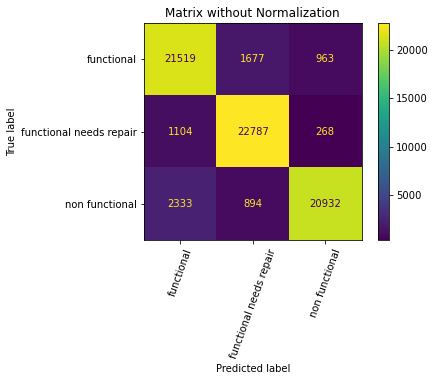

In [141]:
cmx = plot_confusion_matrix(best_model, X_train_resample, y_train_resample,
                            display_labels=encoder.classes_,
                            xticks_rotation=70)
cmx.ax_.set_title('Matrix without Normalization');

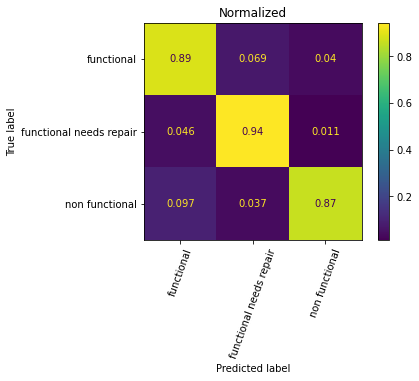

In [143]:
cmx2 = plot_confusion_matrix(best_model, X_train_resample, y_train_resample,
                            display_labels=encoder.classes_,
                                   normalize='true',
                                   xticks_rotation=70)
cmx2.ax_.set_title('Normalized');
#plt.savefig("./Confusion-matrix-not-transparent.png", bbox_inches="tight", transparent=False, dpi=600);

## Feature importance

In [144]:
feature_importances = best_model.best_estimator_.feature_importances_
feature_names = ohe.get_feature_names().tolist()
Feat_names=['Quantity - Dry', 'Quantity - Enough', 'Extraction type - Other', 'Waterpoint type - Other',
   'Quantity - Insufficient', 'Payment - Never pay', 'Payment - Per bucket', 'Extraction type - Gravity',
  'Waterpoint type - Communal standpipe', 'Payment - Monthly']

In [145]:
def plot_feature_importance(importance,names,model_type, n=10):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df=fi_df.head(n)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=Feat_names, palette="ch:start=.2,rot=-.3_r")


    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    

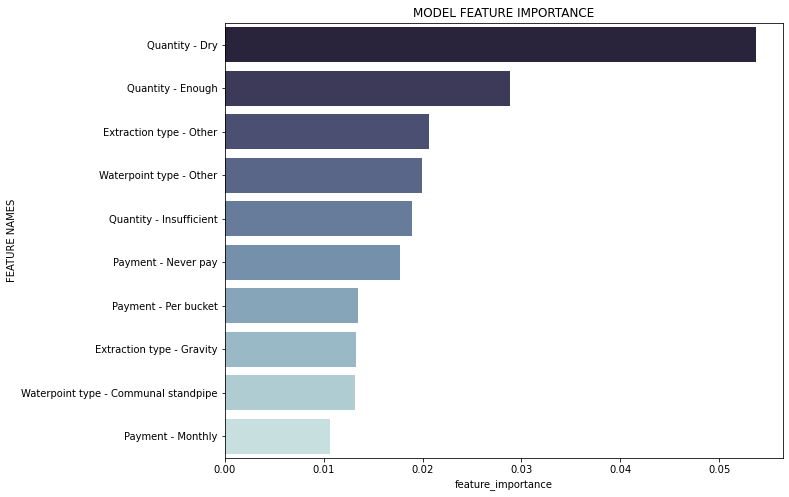

In [146]:
plot_feature_importance(feature_importances,feature_names,'MODEL')
#plt.savefig("./FEATURE_IMPORTANCE-not-transparent.png", bbox_inches="tight", transparent=False, dpi=600);

## Feature Importance Visualizations

In [149]:
df["quantity"].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [150]:
df.loc[df["quantity"] == "insufficient"]["status_group"].value_counts()

functional                 7916
non functional             5763
functional needs repair    1450
Name: status_group, dtype: int64

In [151]:
quan_labels = ['enough', 'seasonal', 'insufficient', 'dry', 'unknown']

quan_func = []
quan_nonfunc = []
quan_func_need_repair = []

for label in quan_labels:
    counts = df.loc[df["quantity"] == label]["status_group"].value_counts(normalize=True)
    quan_func.append(counts["functional"]*100)
    quan_nonfunc.append(counts["non functional"]*100)
    quan_func_need_repair.append(counts["functional needs repair"]*100)

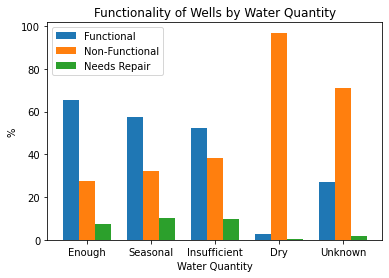

In [152]:
x = np.arange(len(quan_labels))
width = 0.25

fig, ax = plt.subplots()

r1 = np.arange(len(quan_func))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

ax.bar(r1, quan_func, width, label='Functional')
ax.bar(r2, quan_nonfunc, width, label='Non-Functional')
ax.bar(r3, quan_func_need_repair, width, label='Needs Repair')

ax.set_ylabel('%')

ax.set_title('Functionality of Wells by Water Quantity')
ax.set_xlabel('Water Quantity')

plt.xticks([r + width for r in range(len(quan_func))], ['Enough', 'Seasonal', 'Insufficient', 'Dry', 'Unknown'])
ax.legend();

# plt.savefig("../Images/quantity.png", dpi=600, transparent=True);

In [153]:
df["extraction_type"].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [154]:
df.loc[df["extraction_type"] == "gravity"]["status_group"].value_counts(normalize=True)

functional                 0.599253
non functional             0.299888
functional needs repair    0.100859
Name: status_group, dtype: float64

In [155]:
ext_labels = ['gravity', 'nira/tanira', 'submersible', 'swn 80', 'other']

ext_func = []
ext_nonfunc = []
ext_func_need_repair = []

for label in ext_labels:
    counts = df.loc[df["extraction_type"] == label]["status_group"].value_counts(normalize=True)
    ext_func.append(counts["functional"]*100)
    ext_nonfunc.append(counts["non functional"]*100)
    ext_func_need_repair.append(counts["functional needs repair"]*100)

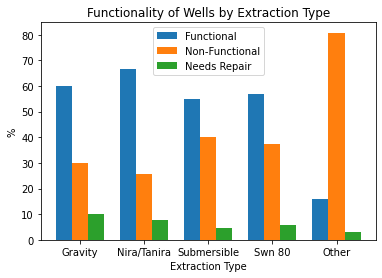

In [156]:
x = np.arange(len(ext_labels))
width = 0.25

fig, ax = plt.subplots()

r1 = np.arange(len(ext_func))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

ax.bar(r1, ext_func, width, label='Functional')
ax.bar(r2, ext_nonfunc, width, label='Non-Functional')
ax.bar(r3, ext_func_need_repair, width, label='Needs Repair')

ax.set_ylabel('%')
ax.set_title('Functionality of Wells by Extraction Type')
ax.set_xlabel('Extraction Type')
plt.xticks([r + width for r in range(len(ext_func))], ['Gravity', 'Nira/Tanira', 'Submersible', 'Swn 80', 'Other'])
ax.legend();

# plt.savefig("../Images/extraction_type.png", dpi=600, transparent=True);

In [157]:
df["payment"].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [158]:
df.loc[df["payment"] == "never pay"]["status_group"].value_counts(normalize=True)

non functional             0.475856
functional                 0.448911
functional needs repair    0.075233
Name: status_group, dtype: float64

In [159]:
pay_labels = ['pay per bucket', 'pay monthly', 'pay when scheme fails', 'never pay', 'unknown']

pay_func = []
pay_nonfunc = []
pay_func_need_repair = []

for label in pay_labels:
    counts = df.loc[df["payment"] == label]["status_group"].value_counts(normalize=True)
    pay_func.append(counts["functional"]*100)
    pay_nonfunc.append(counts["non functional"]*100)
    pay_func_need_repair.append(counts["functional needs repair"]*100)

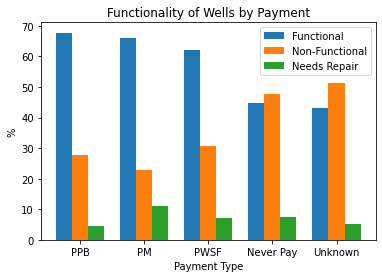

In [160]:
x = np.arange(len(pay_labels))
width = 0.25

fig, ax = plt.subplots()

r1 = np.arange(len(pay_func))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

ax.bar(r1, pay_func, width, label='Functional')
ax.bar(r2, pay_nonfunc, width, label='Non-Functional')
ax.bar(r3, pay_func_need_repair, width, label='Needs Repair')

ax.set_ylabel('%')
ax.set_title('Functionality of Wells by Payment')
ax.set_xlabel('Payment Type')
plt.xticks([r + width for r in range(len(pay_func))], ['PPB', 'PM', 'PWSF', 'Never Pay', 'Unknown'],)
ax.legend();

# plt.savefig("../Images/payment.png", dpi=600, bbox_inches="tight", transparent=True);

## Conclusions

Based on our findings, we reccommend that Tanzania focus on continued use of well-established extraction types (gravity, nira/tanira, submersible, and SWN 80), choose waterpoints with an ample water supply when possible, and initiate payment plans for users of future wells. By doing so, we hope these well will remain functional for as long as possible.

Our model does not cover some metrics where data was too incomplete or poorly-defined that might also be contributing factors, such as elevation, installers/funders, and management. As these are likely to contribute to the performance of these wells, we would like to perform further analysis on these factors in the future we were not able to address in the time we had. We'd also like to interact with the creators of the dataset in order to define terminology used that we were not able to investigate, such as public_meeting and num_private.

In the future, we would also like to investigate the role of seasons and weather in the operation of wells (perhaps based on date of evaluation) and precise location through the provided latitude/longitude coordinates. Provided more time and resources, we would love to dig deeper into this issue and mine more useful information from the source of the data.